In [1]:
import glob
import re
import numpy as np
import pandas as pd

# Importing drive method from colab for accessing google drive
#from google.colab import drive
%matplotlib inline

In [2]:
# Mounting drive
# This will require authentication : Follow the steps as guided (to open a shared folder, make a shortcut to it in your drive!)
#drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras , os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint
from PIL import Image

import cv2
from keras.layers.normalization import BatchNormalization

In [4]:
# folders = '/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData'
# CATEGORIES = []
# for folder,i in zip(folders,range(0,len(folders))):
#     cat = re.split('(/)',folder)
#     CATEGORIES.append(cat[-1])
#     items = len(glob.glob(f"/content/drive/My Drive/FacesData/{CATEGORIES[i]}/*.*"))
#     print (f"{CATEGORIES[i]} has {items} images inside")

In [5]:
data_path ='/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/'

for dir1 in os.listdir(data_path):
    count=0
    for f in os.listdir(data_path + dir1):
        count+=1
    print(f"{dir1} has {count} images")

neutral has 154 images
aggression has 200 images


In [6]:
import random
folder_path="/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/aggression/"
a=random.choice(os.listdir(folder_path))
plt.imread(folder_path+a).shape

(48, 48)

In [7]:
folder_path="/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/neutral/"
a=random.choice(os.listdir(folder_path))
plt.imread(folder_path+a).shape

(250, 200, 3)

In [8]:
agro_path = "/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/aggression/"
neutral_path = "/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/neutral/"
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in pictures
ims_aggression = [read(os.path.join(agro_path, filename)) for filename in os.listdir(agro_path)]
X_aggression = np.array(ims_aggression, dtype='uint8')
ims_neutral = [read(os.path.join(agro_path, filename)) for filename in os.listdir(agro_path)]
X_neutral = np.array(ims_neutral, dtype='uint8')

In [9]:
X_aggression.shape

(200, 48, 48, 3)

In [10]:
X_neutral.shape   #need to reize it

(200, 48, 48, 3)

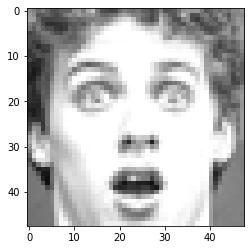

In [11]:
#Make sure the images are loaded
plt.imshow(X_aggression[2]) 
plt.show()  # display it

In [12]:
X_neutral_1=[]
for img in range (len(X_neutral)):
    input_img_resize=cv2.resize(X_neutral[img],(48,48))
    X_neutral_1.append(input_img_resize)

In [13]:
X_neutral_1=np.array(X_neutral_1)
X_neutral_1.shape   #now we have the same size for each class with tensor

(200, 48, 48, 3)

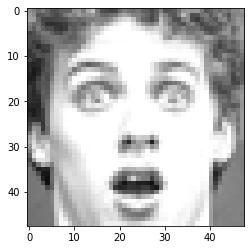

In [14]:
plt.imshow(X_neutral_1[2]) 
plt.show()  # display it

In [15]:
# Create labels
y_neutral = np.zeros(X_neutral_1.shape[0])
y_aggression = np.ones(X_aggression.shape[0])

In [16]:
X = np.concatenate((X_neutral_1, X_aggression), axis = 0)

In [17]:
# Merge data and shuffle it
X = np.concatenate((X_neutral_1, X_aggression), axis = 0)
y = np.concatenate((y_neutral, y_aggression), axis = 0)
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
y = y[s]

In [18]:
X.shape,y.shape

((400, 48, 48, 3), (400,))

In [19]:
X_scaled = X/255


In [20]:
from keras.applications import VGG16
import keras.utils
IMAGE_SIZE = [48, 48] 
# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (48,48,3) as required by VGG

In [21]:
print('Output_layer_type= {}'.format(vgg.layers[-1]))
print('Output_layer_shape= {}'.format(vgg.layers[-1].output_shape))

Output_layer_type= <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fefd2b31690>
Output_layer_shape= (None, 1, 1, 512)


In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
x = Flatten()(vgg.output)

In [24]:
num_classes=1
x = Dense(num_classes, activation = 'sigmoid')(x)  # adding the output layer

In [25]:
from keras.models import Model
model = Model(inputs = vgg.input, outputs = x)

loss function was selected is binary crossentropy:

The loss function binary crossentropy is used only 2 labels yes/no decisions or 1/0, it is a sigmoid activation in the last (output) layer and it's output is a probability value take range from 0 to 1 in almost cases if the prediction more than 0.5 so the class is 1 otherwise will be 0

In [26]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
#show connections for the data flow
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [28]:
from keras.preprocessing.image import ImageDataGenerator

In [29]:
#Data Augmentation

trainAug = ImageDataGenerator(rotation_range=30,zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2,
                              shear_range=0.15,horizontal_flip=True)

In [30]:
trainAug.fit(X_scaled)

In [31]:
X_train,X_val,y_train,y_val=train_test_split(X_scaled,y,test_size=0.20,random_state=42)

print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

X_train shape (320, 48, 48, 3)
X_test shape (80, 48, 48, 3)
y_train shape (320,)
y_test shape (80,)


In [32]:
from keras.callbacks import Callback,EarlyStopping
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [34]:
batch_size = 32
steps_per_epoch=len(X_train)
validation_steps=len(y_val)

In [35]:
def run_aggression():
    
    history = LossHistory()
    model.fit(trainAug.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch = steps_per_epoch,
    epochs = 5,
    verbose = 2,
    validation_data = (X_val,y_val),
    validation_steps = validation_steps, callbacks=[history, early_stopping])
    

    return history

In [36]:
history = run_aggression()

Epoch 1/5
 10/320 - 3s - loss: 0.7744 - accuracy: 0.5125 - val_loss: 0.7872 - val_accuracy: 0.4625


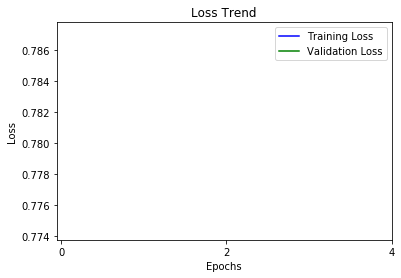

In [37]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,5)[0::2])
plt.legend()
plt.show()

In [38]:
model.save('Agg_detect.h5')
model.save_weights('model_weightAgg_detect.h5')

In [39]:
from keras.models import load_model

model_loaded = load_model('Agg_detect.h5')

In [40]:
#test class any image here
from keras.preprocessing import image

test_image=image.load_img('/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/dataset/aggression/S010_002_00000012.png',target_size=(48,48))
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model_loaded.predict(test_image)

if result[0][0] >=0.5:
    prediction='Aggressive'
else:
    prediction='Natural'
print(prediction)

Aggressive


In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier('/Users/ashnakhetan/Desktop/Ashna/EMPath/FacesData2/haarcascade_frontalface_default.xml') # We load the cascade for the face.
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (5,100)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

video_capture = cv2.VideoCapture(0) # We turn the webcam on.

while True: # We repeat infinitely (until break):
    _, frame = video_capture.read() # We get the last frame.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # We do some colour transformations.
    #canvas = detectFaces(gray, frame) # We get the output of our detect function.
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(50, 50)) # We apply the detectMultiScale method from the face cascade to locate one or several faces in the image.
    for (x, y, w, h) in faces: # For each detected face:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2) # We paint a rectangle around the face without any border.
        #roi_gray = gray[y:y+h, x:x+w] # We get the region of interest in the black and white image.
        roi_color = frame[y:y+h, x:x+w] # We get the region of interest in the colored image.
        #print(x, y, w, h)
        test_image=image.img_to_array(roi_color)
        test_image = cv2.resize(test_image, (48,48))
        test_image=np.expand_dims(test_image,axis=0)
        result=model_loaded.predict(test_image)
        #result=str(result)
        if result[0][0]>0.5:
            prediction='Aggression'
        else:
            prediction='Natural'
        cv2.putText(frame,prediction,bottomLeftCornerOfText,font,fontScale,fontColor,lineType)
    
        cv2.imshow('Video', frame) # We display the outputs.
    if cv2.waitKey(1) & 0xFF == ord('q'): # If we type on the keyboard:
        break # We stop the loop.

video_capture.release() # We turn the webcam off.
cv2.destroyAllWindows() # We destroy all the windows inside which the images were displayed.

In [ ]:
def detect(gray, frame): # We create a function that takes as input the image in black and white (gray) and the original image (frame), and that will return the same image with the detector rectangles. 
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(50, 50)) # We apply the detectMultiScale method from the face cascade to locate one or several faces in the image.
    for (x, y, w, h) in faces: # For each detected face:
        #cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 0), 0) # We paint a rectangle around the face without any border.
        #roi_gray = gray[y:y+h, x:x+w] # We get the region of interest in the black and white image.
        roi_color = frame[y:y+h, x:x+w] # We get the region of interest in the colored image.
        #print(x, y, w, h)
        test_image=image.img_to_array(roi_color)
        test_image = cv2.resize(test_image, (48,48))
        test_image=np.expand_dims(test_image,axis=0)
        result=model_loaded.predict(test_image)
        if result[0][0] >=0.4:
            prediction='Agg'
        else:
            prediction='Nat'

        return result # We return the detector rectangles area.

In [ ]:
img1 = cv2.imread('image1.png')  #pass 0 to convert into gray level 
img1=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [ ]:
str(detect(gray,img1)[0][0]) # We get the output shap our detect function.)

In [ ]:
img2= cv2.imread('image2.png')  #pass 0 to convert into gray level 
img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [ ]:
detect(gray, img2) # We get the output shap our detect function.